# 타이타닉 생존자 예측 해보기

Survived : 0 = 사망, 1 = 생존  
Pclass : 1 = 1등석, 2 = 2등석, 3 = 3등석  
Sex : male = 남성, female = 여성  
Age : 나이  
SibSp : 타이타닉 호에 동승한 자매 / 배우자의 수  
Parch : 타이타닉 호에 동승한 부모 / 자식의 수  
Ticket : 티켓 번호  
Fare : 승객 요금  
Cabin : 방 호수  
Embarked : 탑승지, C = 셰르부르, Q = 퀸즈타운, S = 사우샘프턴  

## 1. 문제 정의

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
train = pd.read_csv('./train (1).csv')
test = pd.read_csv('./test (1).csv')

train.head()    

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


데이터는 타이타닉호 탑승객들의 신상 정보를 series로 갖는 dataframe으로 구성 되어있다.  
승객별로 생존 여부가 모두 라벨링 되어있으므로 지도학습에 해당된다.  
또한 여러개의 변수를 이용하여 최종적으로 생존(1), 사망(0)을 나눠야 하는 이진 분류 문제이다.

## 2. 데이터 살펴보기

데이터는 학습 시키기 전 전처리를 해서 깨끗한 상태로 정제 해야한다. 이를 위해 데이터의 형태와 크기를 알아보고  
결측치를 파악하여 어떠한 상태로 가공할 것인지 방향을 정한다.

### 2.1 데이터 딕셔너리

데이터의 각 column은 Name, Age등 직관적으로 파악이 되는 경우도 있지만, sibSp, Parch등 과 같이 의미하는 바가 명확하지 않은 경우도 있다.

### 2.2 결측치 파악  
우선 데이터의 형태를 알아보자.

In [4]:
train.shape

(891, 12)

In [7]:
test.shape

(418, 11)

훈련 데이터는 891개의 행과 12개의 열로 이루어져있다.  
훈련 데이터로 학습 시킨 모델을 통해 라벨링을 해야하므로 타깃(라벨)에 해당하는 survived열이 빠진 상태이다.

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


info()는 dataframe에 대해 각 series(column)의 타입(정수, 실수, 문자등)과 결측치 개수의 정보를 요약해서 보여준다.  
결측치가 정확히 몇 개 인지는 아래 코드를 통해 확인할 수 있다.  

pandas의 info()는 메소드는 dataframe에만 적용할 수 있고, series에는 쓸 수 없다.

In [10]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## 2.3 데이터 시각화 

각 column들을 시각화 하여 대략적인 분포를 파악하고 타겟(생존여부)과의 상관 관계를 유추한다.  
우선 명목형, 이산형 데이터들에 대해 막대형 그래프를 그려주는 함수를 하나 정의한다.

In [14]:
def bar_chart(feature):
    # 각 column(=feature)에서 생존자 수 count
    survived = train[train['Survived']==1][feature].value_counts()

    # 각 column(=feature)에서 생존자 수 count
    dead = train[train['Survived']==0][feature].value_counts()

    # 생존자 수, 사망자 수를 하나의 dataframe으로 묶는다.
    df = pd.DataFrame([survived,dead])

    # 묶은 dataframe의 인덱스명(행 이름)을 지정한다.
    df.index = ['Survived', 'Dead']

    # plot을 그린다.
    df.plot(kind='bar', stacked=True, figsize=(10,5))

    # return df

pandas의 value_counts()는 dataframe에는 적용할 수 없고, series에 적용한다.  
해당 메서드의 return값 역시 series이다.

명목, 이산형 데이터에 해당하는 feature들의 그래프를 그려보자. SibSp와 parch는 의미상 큰 차이가 없으므로 하나만 그린다. 

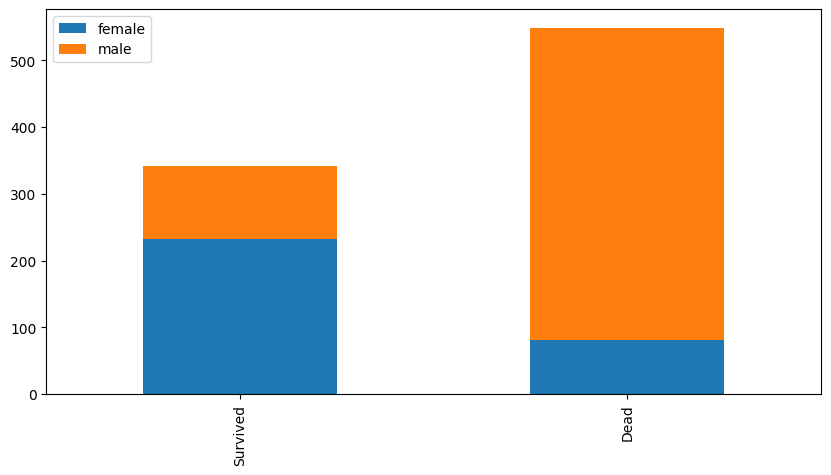

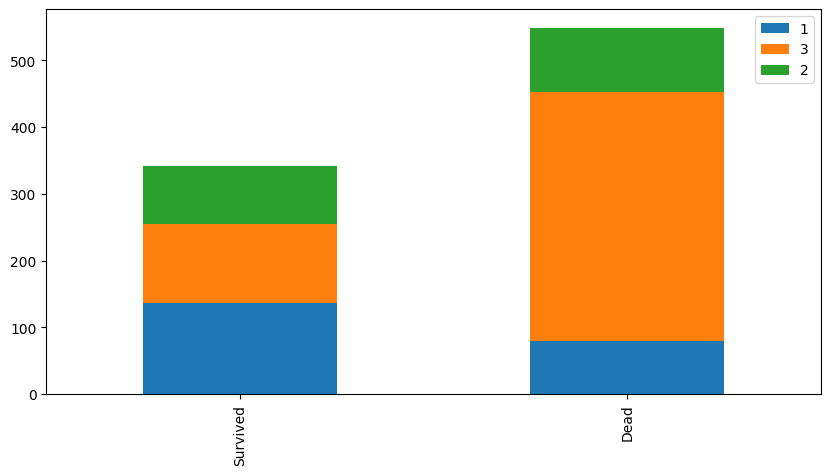

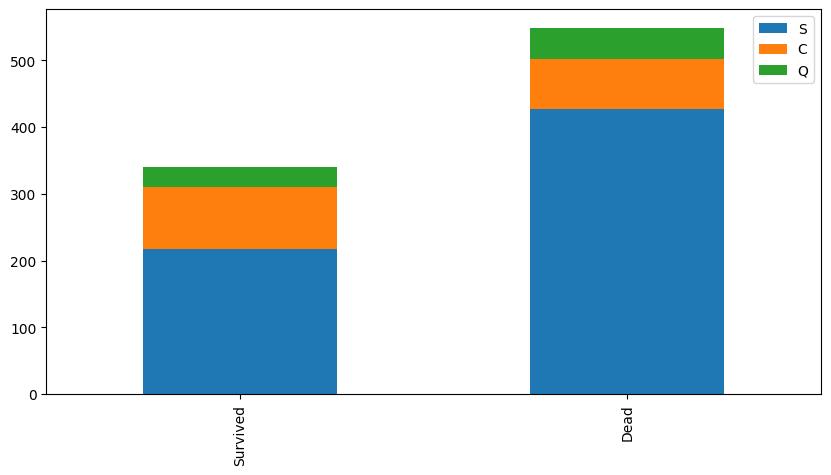

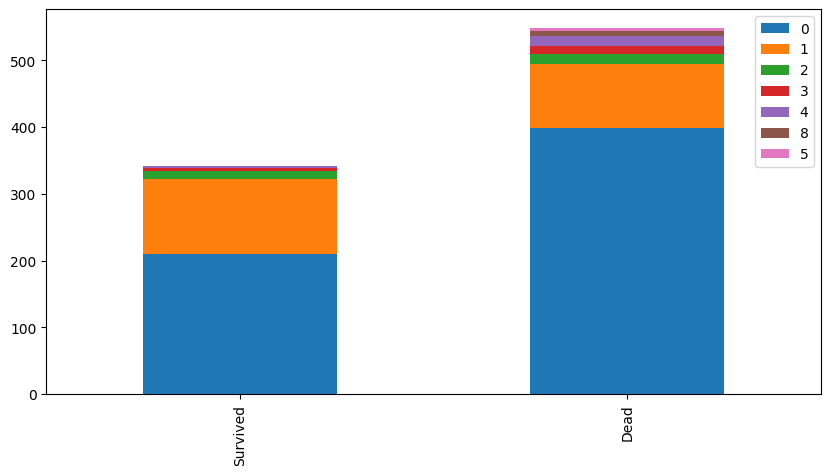

In [15]:
bar_chart('Sex')
bar_chart('Pclass')
bar_chart('Embarked')
bar_chart('SibSp')

데이터를 시각화 하여 분석한 결과 남성보단 여성이 많이 생존 했으며 1등급 승객, 가족이 있는 승객이 생존률이 높았다.   
탑승 지역에서의 특별한 경향은 아직 보인다고 말하긴 어려워 보이지만 비율상으로 S 승객들이 많이 사망했다.

# 3. 데이터 전처리

정제가 필요한 column에 대해서 전처리를 진행한다.

## 3.1 Sex

성별 데이터는 결측치도 없고 분류도 이미 끝나있다. 학습이 잘 진행될 수 있도록 각 문자들을 숫자에 대응시킨다.

In [17]:
train_test_data = [train, test]

sex_mapping = {'male': 0, 'female': 1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

testset과 trainset을 모두 전처리 해야 하므로 하나의 리스트로 묶어 for문을 통해 한번에 처리하도록 한다. 

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


## 3.2 SibSp & Parch

해당 칼럼이 의미하는 바는 결국 가족의 수이다.  
앞서 시각화에서 관찰했듯이 동승자의 여부는 생존율과 유의미한 관계가 있으므로 SibSp와 parch를 familysize로 묶는다.  
그리고 이를 통해 동승자 여부를 판단하는 IsAlone이라는 변수를 생성한다.

In [21]:
for dataset in train_test_data:
    # 가족수 = 형제자매 + 부모님 + 자녀 + 본인
    dataset['Familysize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1

    # 가족수 1 이상이면 동승자 있음
    dataset.loc[dataset['Familysize']>1, 'IsAlone'] = 0

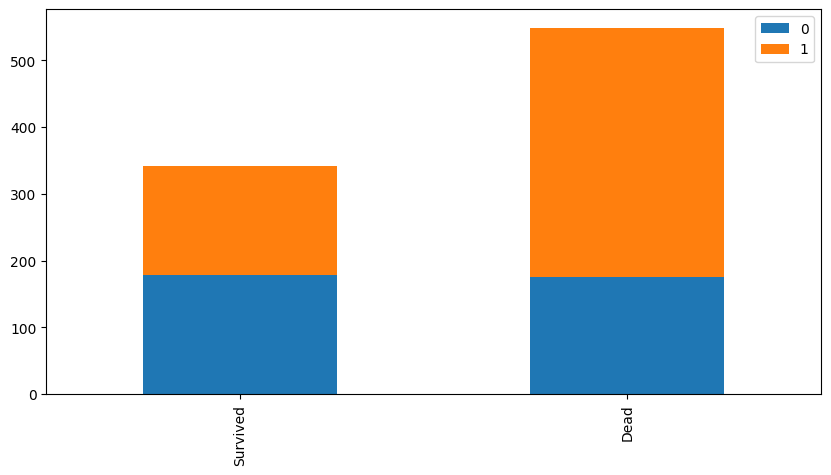

In [22]:
bar_chart('IsAlone')

위에서 확인한대로 혼자 탄 사람이 많이 죽었음을 확인할 수 있다.  

In [23]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Familysize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1,1


## 3.3 Embarked

시각화 결과 S승객들이 사망한 비율이 높았다. 거주지역의 차이가 경제적 지표를 나타낼 수도 있으므로 등급별 승객들의 지역 분포를 시각화해서 살펴보자.

In [25]:
class_list = []
for i in range(1,4):
    series = train[train['Pclass'] == i]['Embarked'].value_counts()
    class_list.append(series)

series = train[train['Pclass'] == i]['Embarked'].value_counts(): 이 코드 행은 train DataFrame을 필터링하여 Pclass 열이 현재 열과 일치하는 행을 선택합니다. 'i'의 값. 그런 다음 필터링된 행에서 'Embarked' 열을 검색하고 'value_counts()' 함수를 사용하여 각 고유 값의 개수를 계산합니다. 결과는 series 변수에 저장됩니다.  

class_list.append(series): class_list 목록에 series 개체를 추가합니다. 각 'series' 개체는 특정 'Pclass'의 승객 수를 나타냅니다.  

결과 class_list는 3개의 series 개체 목록이 되며 각 series 개체는 특정 승객 클래스의 승객 수를 나타냅니다. 각 'series' 객체는 고유한 승선 포트를 인덱스로, 각 포트의 승객 수를 해당 값으로 갖습니다.

In [26]:
print(class_list)

[S    127
C     85
Q      2
Name: Embarked, dtype: int64, S    164
C     17
Q      3
Name: Embarked, dtype: int64, S    353
Q     72
C     66
Name: Embarked, dtype: int64]
